# Dark Matter Detection with Qubits

In addition to so called normal matter that is made of protons and neutrons, there is dark matter in the universe [[1]](#references). It is still not known what dark matter is and it is difficult to observe it as dark matter does not interact with ordinary matter or radiation [[2]](#references). One candidate for what dark matter is, is the axion. Axions are light particles with masses in the $\mu eV$ range and they should couple to photons in strong magnetic fields [[3]](#references). The coupling could lead to additional electrical current or non-typical magnetic fields.

Qubits can be used as sensors, as they are very sensitive to external disturbances. One proposition for finding the axion dark matter is detecting it with qubits [[4,5,6]](#references). The proposed method presents an experiment setup with a qubit that is surrounded by a magnetic field. Once the axion passes through the magnetic field it will couple to a photon. This photon will excite the qubit. The system will be isolated and thus will be excited only by an axion-photon interaction. Some errors and noise, like the readout error from the qubit, are still taken into account.

The signals that might excite the qubit are usually very faint and they could be enhanced by a quantum circuit [[4,5,6]](#references). In this notebook, the enhancement circuit is presented and it is run on a real quantum computer, the Q50, or a simulator. As the quantum computer is not made to be a sensor, this will be a simulation of how an experiment for detecting axion dark matter could be performed. Nevertheless, the results from the enhancement circuit can still be observed and the use of quantum computing for fundamental physics can be demonstrated.

If you want to know more about the detection of axion dark matter with qubits, a blog post written about the topic can be found [here](https://github.com/FiQCI/fiqci.github.io/tree/master/content/_publications/2025-08-21-Dark-Matter-Detection.md).

In [15]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os

from qiskit_aer import Aer
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from iqm.qiskit_iqm import IQMProvider, IQMFakeAphrodite

### The axion interaction with the qubit

As the axion couples to a photon, the photon will interact with the qubit. The interaction can be described with a unitary transformation that contains information about the dark matter particle and about the qubit [[4,5,6]](#references). The unitary operator, $U_{DM}$, can be approximated as:

$$ 
U_{DM} \approx \begin{pmatrix} \cos(\eta\tau) & i e^{-i\alpha} \sin(\eta\tau) \\ i e^{i\alpha} \sin(\eta\tau) & \cos(\eta\tau) \end{pmatrix} 
$$
where $\tau$ is the decoherence time, $\eta$ is a variable containing the the dark matter and qubit properties, and $\alpha$ is a random phase from the axion oscillation [[5,6]](#references). However, this unitary can still be further simplified. It can be done by assuming that the qubit and the dark matter frequencies are close to each other and by absorbing the evolution phase $e^{\pm i \alpha}$ into the definition of the excited state of the qubit [[5,6]](#references). Now the unitary will look like:

$$ 
U_{DM} \approx \begin{pmatrix} \cos(\eta\tau) & i \sin(\eta\tau) \\ i \sin(\eta\tau) & \cos(\eta\tau) \end{pmatrix} 
$$

The variable $\eta$ can also be opened so that it can be seen what the unitary transformation really is dependent on,
$$
\eta = 1/2 \epsilon\kappa d \sqrt(C\omega\rho_{dm})cos\Theta
$$

where $\epsilon$ is the kinetic mixing parameter that describes the coupling, $\kappa$ is the package coefficient, $d$ is the effective distance between two conductor plates, $C$ is the capacitance of the conductor, $\omega$ is the energy difference between the ground and excited states of the qubit, $\rho_{dm}$ is the energy density of the dark matter, and $\Theta$ is the angle between the electric field induced by the photon and the normal vector of the capacitor [[5,6]](#references). In the dark matter search, it is assumed that the energy difference $\omega$ is equal to the mass of the dark matter axion, $m_{dm}$ [[5]](#references). This will enhance the excitation rate and the dark matter particles can be observed just by measuring if the qubit has been excited or not. This assumption also means that the qubit frequency is equal to the mass of the axion. Thus, to scan through the range of possible masses of the axion, the value of the qubit frequency will be changed to the value of the mass that is wanted to be observed [[5]](#references).

### The enhancement circuit

The signals from the axion-photon interaction are very weak, but they can be enhanced with Greenberg-Horne-Zeilinger (GHZ) states [[5,6]](#references). This means that instead of one qubit there is N qubits that can sense the axion-photon interaction. The qubits are first initialized to the ground state, then a Hadamard gate is applied to each qubit, except the first one, and they are entangled with, for example, CNOT gates. This state now evolves during a time $\tau$ and in this example it will evolve according to $U_{DM}$. During the evolution the state picks up a phase that is enhanced by a factor of N. Then the inverse of the entangling gates are applied and the first qubit is measured. The transition probability of the qubit is now higher.

Below the $U_{DM}$ is created with parameter values that are found from research, [[4,5,6]](#references), and the enhancement circuit is made and run for the different $U_{DM}$. In the end a graph of the probabilities is shown. The effect of the amount of qubits can be compared by changing the parameter $k$. 

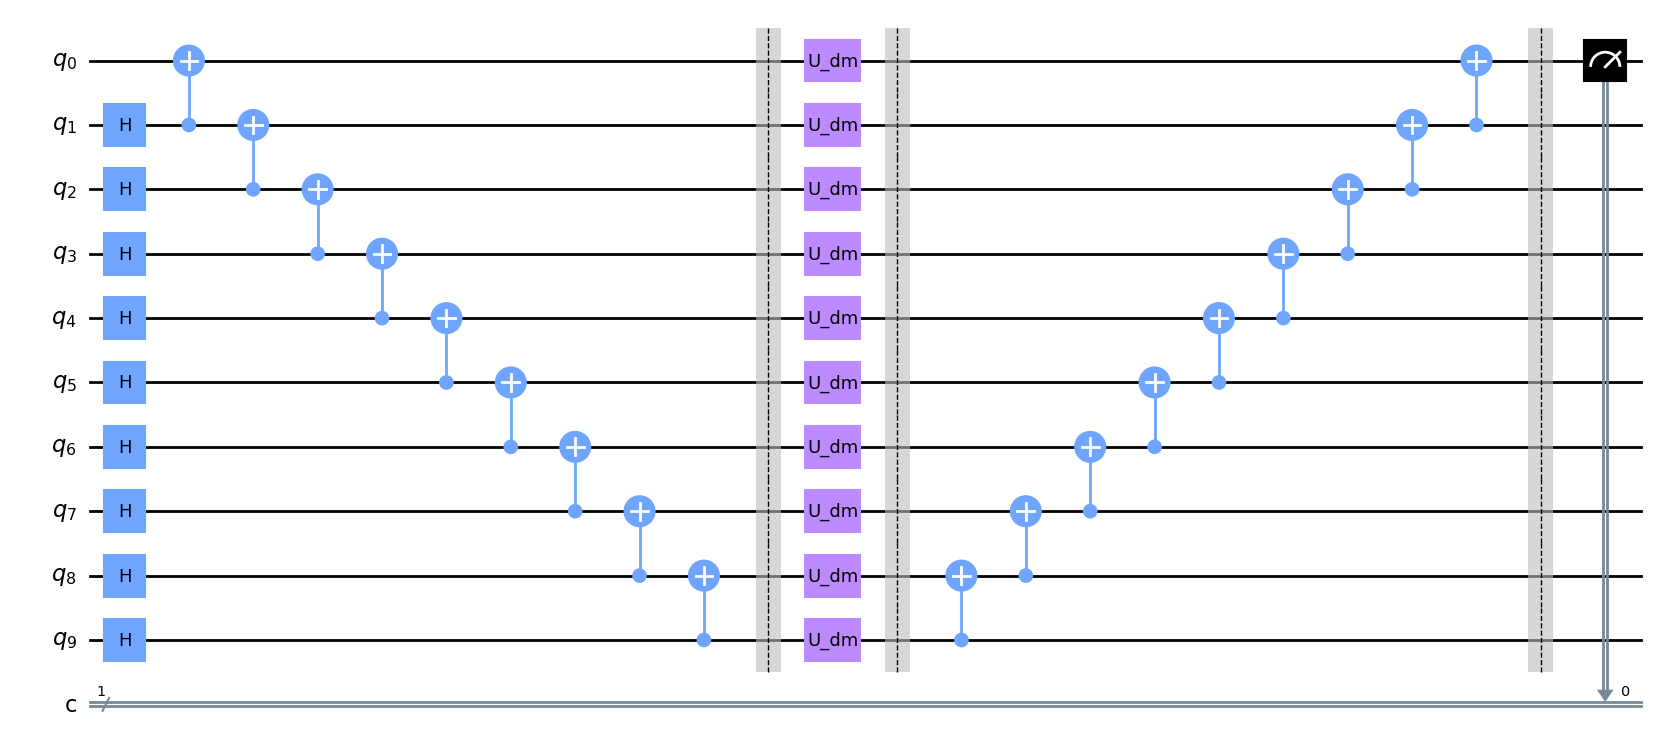

In [16]:
# Creating the quantum circuit to enhance signals

# Start by defining the possible mass and kinetic mixing parameter
# In this example it is assumed these are linearly dependant and paired elementwise
m_dm = np.linspace(10, 100, 100) # mueV
e = np.linspace(10**(-3),10, 100) # 10e-11 scaling factor

# Define the constants
C = 0.1 # pF
d = 100 # µm
rho_dm = 0.45 # GeV/cm^3
k = 10 # number of qubits 
theta = np.deg2rad(54.74) # degrees to radians


# Create the n parameter for the axion, used later in the circuit
n  = 0.5 * e * k * d * np.sqrt(C * m_dm * rho_dm) * np.cos(theta)

# The decoherence time of the dark matter, the decoherence time of the qubits is assumed to be larger
t = 10**(-4) # s

# A loop to compute the unitary transformation caused by the dark matter for each value of n
U_dm = []
for i in range(len(n)) :
    a = np.cos(n[i]*t)
    b = 1j*np.sin(n[i]*t)

    U = np.array([
    [a, b],
    [b, a]
    ])

    U_dm.append(UnitaryGate(U, label="U_dm"))

# A function that creates the enhancement circuit 
def dm_qc(u):
    qc = QuantumCircuit(k,1)
    # If there is only one qubit use the unitary gate but no enhancement circuit made
    if k == 1 :
        qc.append(u, [0])
    # With more qubits use the enhancement circuit and the unitary gate
    else : 
        # The CNOTs
        for i in range(k):
            if i+1 < k:
                qc.h(i+1)
                qc.cx(i+1,i)
        qc.barrier()
        # The unitary gate acting as the fake dark matter signal
        for i in range(k):
            qc.append(u, [i])
        qc.barrier()
        # The CNOTs again
        for i in reversed(range(k)):
            if i + 1 < k:
                qc.cx(i+1, i)
        qc.barrier()
    # Measure the first qubit
    qc.measure(0,0)
    
    return qc

# Drawing the circuit for one of the possible U_dm    
dm_qc(U_dm[0]).draw(output="mpl", style="clifford")
    

In [17]:
# Running the circuit and getting the probabilities for analysis
# An empty list for saving the probabilities
probability_excited = []

# Getting the backend
# A simulator backend that is like the Q50 quantum computer
backend = IQMFakeAphrodite()
#backend = Aer.get_backend('statevector_simulator') # or a statevector simulator as the backend
# The real Q50 backend
# Q50_CORTEX_URL = os.getenv('Q50_CORTEX_URL')
# provider_q50 = IQMProvider(Q50_CORTEX_URL)
# backend_q50 = provider_q50.get_backend()

# Build circuits using all of the U_dms. 
circuits = [dm_qc(U) for U in U_dm]

# Transpile all of the circuits
transpiled_circuits = transpile(circuits, backend=backend, seed_transpiler=1,optimization_level=1)

# Run all as a batch job
# Running the circuits as a batch job will be faster and save QPU time
job = backend.run(transpiled_circuits, shots=1024)

# Get results
results = job.result()

# Get the probability for the qubit being in state 1 from every circuit
probability_excited = []
for i in range(len(transpiled_circuits)):
    counts = results.get_counts(i)
    p1 = counts.get('1', 0) / 1024
    probability_excited.append(p1)

print(probability_excited)

[0.2744140625, 0.2705078125, 0.2724609375, 0.2734375, 0.259765625, 0.265625, 0.28125, 0.267578125, 0.2705078125, 0.275390625, 0.2861328125, 0.296875, 0.3173828125, 0.333984375, 0.3212890625, 0.375, 0.353515625, 0.4091796875, 0.373046875, 0.416015625, 0.44140625, 0.4443359375, 0.4716796875, 0.4912109375, 0.51171875, 0.5234375, 0.5361328125, 0.5595703125, 0.5791015625, 0.6083984375, 0.625, 0.6513671875, 0.6806640625, 0.6630859375, 0.7080078125, 0.7158203125, 0.693359375, 0.6884765625, 0.6953125, 0.703125, 0.689453125, 0.68359375, 0.6689453125, 0.7001953125, 0.669921875, 0.63671875, 0.625, 0.58203125, 0.59765625, 0.5556640625, 0.5458984375, 0.505859375, 0.49609375, 0.4658203125, 0.3974609375, 0.380859375, 0.384765625, 0.3642578125, 0.3388671875, 0.322265625, 0.2978515625, 0.291015625, 0.2861328125, 0.29296875, 0.2578125, 0.3173828125, 0.3486328125, 0.3486328125, 0.375, 0.4091796875, 0.4208984375, 0.4287109375, 0.4677734375, 0.5068359375, 0.5390625, 0.5927734375, 0.60546875, 0.6220703125, 

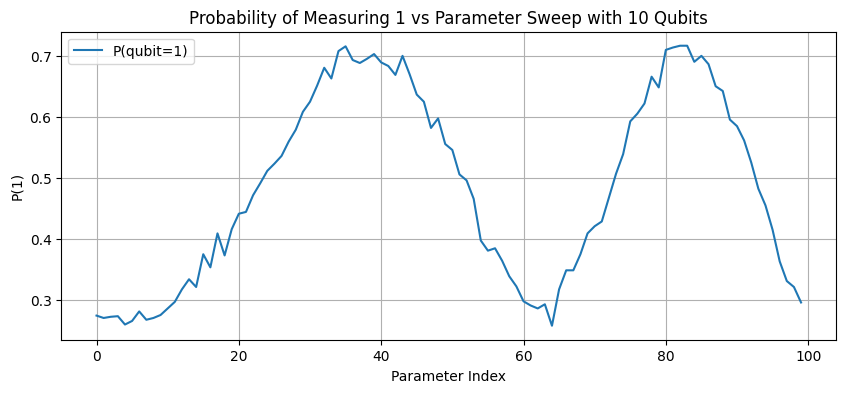

In [18]:
# Plot probability vs index 
# The graph shows with which index the qubit is most likely excited --> the mass and kinetic mixing parameter can be found with the index
plt.figure(figsize=(10, 4))
plt.plot(probability_excited, label='P(qubit=1)')
plt.xlabel("Parameter Index")
plt.ylabel("P(1)")
plt.title("Probability of Measuring 1 vs Parameter Sweep with 10 Qubits")
plt.legend()
plt.grid(True)
plt.show()

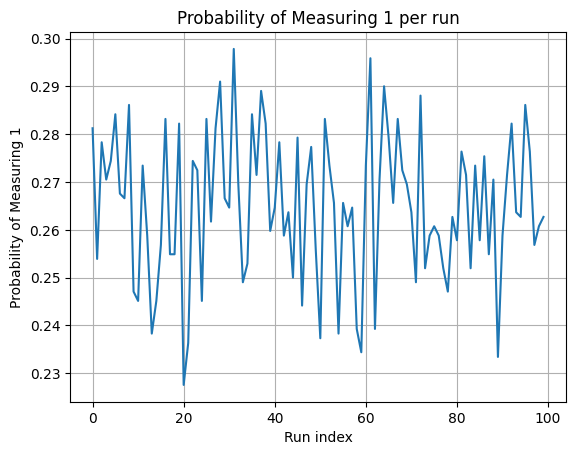

In [19]:
# The enhancement circuit without a dark matter signal
# This code block is to show what the circuit would produce without a simulated dark matter signal

# Create the enhancement circuit, it will be the same as before except U_dm is replaced by an identity gate 
# (i.e. nothing happens to the circuit during the time when the U_dm previously was acting on the circuit)
def no_dm():
    qc = QuantumCircuit(k,1)
    # With one qubit only use the identity gate
    if k == 1 :
        qc.id(0) # <-- identity gate
    # For multiple qubits use the enhancement circuit and the identity gate
    else : 
        for i in range(k):
            if i+1 < k:
                qc.h(i+1)
                qc.cx(i+1,i)
        qc.barrier()
        for i in range(k):
            qc.id(i) # <-- identity gate
        qc.barrier()
        for i in reversed(range(k)):
            if i + 1 < k:
                qc.cx(i+1, i)
        qc.barrier()
    # MEasure the first qubit
    qc.measure(0,0)
    
    return qc

# Number of separate runs, matches the amount of points in the lists for dark matter mass and kinetic mixing parameter
n_repeats = 100
# Will store the probability for each run  
all_probabilities = []  

# Run the circuit without the simulated dark matter signal n_repeats times and save the probabilities
for run_idx in range(n_repeats):

    # Build the circuit on each run
    circuit = no_dm() 

    # Transpile
    transpiled_circuits = transpile(
        circuit,
        backend=backend,
        seed_transpiler=1,
        optimization_level=1
    )

    # Run the circuit
    job = backend.run(transpiled_circuits, shots=1024)
    results = job.result()

    # Extract P(1) for this run
    counts = results.get_counts()
    p1 = counts.get('1', 0) / 1024

    # Add it to the list of all of the probabilities
    all_probabilities.append(p1)

# Plot the probabilities from each run
plt.plot(range(n_repeats), all_probabilities)
plt.xlabel('Run index')
plt.ylabel('Probability of Measuring 1')
plt.title('Probability of Measuring 1 per run')
plt.grid(True)
plt.show()

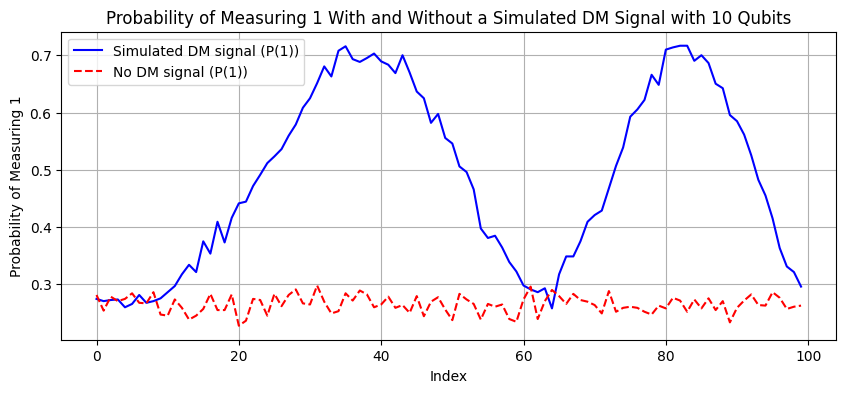

In [20]:
# The probability of the first qubit being in the excited state with and without the simulated dark matter signal on the same plot

plt.figure(figsize=(10, 4))

# With the simulated dark matter signal
plt.plot(probability_excited, label='Simulated DM signal (P(1))', color='blue')

# Without the simulated dark matter signal
plt.plot(all_probabilities, label='No DM signal (P(1))', color='red', linestyle='--')

plt.xlabel("Index")
plt.ylabel("Probability of Measuring 1")
plt.title("Probability of Measuring 1 With and Without a Simulated DM Signal with 10 Qubits")
plt.legend()
plt.grid(True)
plt.show()

## References

[1] S. Profumo, "An introduction to particle dark matter," arXiv preprint arXiv:1910.05610, Oct. 2019. [Online]. Available: https://arxiv.org/pdf/1910.05610

[2] B. R. Garrett and D. E. McKay, "Dark matter: A primer," arXiv preprint arXiv:1006.2483, Jan. 2011. [Online]. Available: http://arxiv.org/pdf/1006.2483

[3] Chadha-Day, F., Ellis, J., and Marsh, D. J. E., “Axion dark matter: What is it and why now?”, <i>Science Advances</i>, vol. 8, no. 8, Art. no. eabj3618, 2022. doi:10.1126/sciadv.abj3618

[4] S. Chen, H. Fukuda, T. Inada, T. Moroi, T. Nitta, and T. Sichanugrist, “Detection of hidden photon dark matter using the direct excitation of transmon qubits,” arXiv preprint arXiv:2212.03884, Dec. 2022. [Online]. Available: https://arxiv.org/pdf/2212.03884

[5] S. Chen, H. Fukuda, T. Inada, T. Moroi, T. Nitta, and T. Sichanugrist, “Search for QCD axion dark matter with transmon qubits and quantum circuit,” arXiv preprint arXiv:2407.19755, Jul. 29, 2024. [Online]. Available: https://arxiv.org/pdf/2407.19755

[6] S. Chen, H. Fukuda, T. Inada, T. Moroi, T. Nitta, and T. Sichanugrist, “Quantum enhancement in dark matter detection with quantum computation,” arXiv preprint arXiv:2311.10413, revised Jul. 30, 2024. [Online]. Available: https://arxiv.org/pdf/2311.10413